In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, accuracy_score,r2_score,mean_absolute_error,root_mean_squared_error

In [2]:
data= pd.read_csv("processor_data.csv")
data.head(5)

,transaction_id,amount,currency,country,processor,timestamp,payment_method,merchant_category,volume,status,error_code,latency_ms
0,txn_000000,495.37,NGN,Nigeria,Processor_D,2025-07-12 06:11:27.770024,Digital Wallet,Retail,91,success,NaN,115.92
1,txn_000001,59.42,INR,India,Processor_C,2025-06-27 11:24:46.770024,Digital Wallet,Travel,71,success,NaN,118.69
2,txn_000002,685.25,BRL,Brazil,Processor_D,2025-07-23 14:09:41.770024,Debit Card,Digital Goods,105,failed,ERR_NETWORK,184.08
3,txn_000003,798.05,GBP,UK,Processor_A,2025-07-18 10:53:23.770024,Crypto,Digital Goods,95,success,NaN,124.11
4,txn_000004,291.09,EUR,Germany,Processor_B,2025-07-02 13:48:27.770024,Credit Card,Retail,82,success,NaN,95.43


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     50000 non-null  object 
 1   amount             50000 non-null  float64
 2   currency           50000 non-null  object 
 3   country            50000 non-null  object 
 4   processor          50000 non-null  object 
 5   timestamp          50000 non-null  object 
 6   payment_method     50000 non-null  object 
 7   merchant_category  50000 non-null  object 
 8   volume             50000 non-null  int64  
 9   status             50000 non-null  object 
 10  error_code         4608 non-null   object 
 11  latency_ms         50000 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 4.6+ MB


In [4]:
data.duplicated().sum()

np.int64(0)

In [5]:
data.isnull().sum()

transaction_id           0
amount                   0
currency                 0
country                  0
processor                0
timestamp                0
payment_method           0
merchant_category        0
volume                   0
status                   0
error_code           45392
latency_ms               0
dtype: int64

In [6]:
data.shape

(50000, 12)

In [7]:
data['hour_of_day'] = pd.to_datetime(data['timestamp']).dt.hour

bins = [5, 12, 17, 21, 24]
labels = ['Morning', 'Afternoon', 'Evening', 'Late Night']
data['time_of_day'] = pd.cut(data['hour_of_day'], bins=bins, labels=labels, right=False, include_lowest=True)


In [8]:
# # You can keep this for Altair plotting if needed, it doesn't affect ML pipeline directly
# grouped_data = data.groupby(['processor', 'status', 'time_of_day']).size().reset_index(name='count')
# time_of_day_order = ['Night', 'Morning', 'Afternoon', 'Evening', 'Late Night']
# grouped_data['time_of_day'] = pd.Categorical(grouped_data['time_of_day'], categories=time_of_day_order, ordered=True)
# chart.show() # Uncomment if you want to display the chart

# --- 2. Drop Unnecessary Columns for ML Model ---
df = data.drop(columns=["transaction_id", "error_code", "hour_of_day", "timestamp"], axis=1)

In [9]:
df.head(10)

,amount,currency,country,processor,payment_method,merchant_category,volume,status,latency_ms,time_of_day
0,495.37,NGN,Nigeria,Processor_D,Digital Wallet,Retail,91,success,115.92,Morning
1,59.42,INR,India,Processor_C,Digital Wallet,Travel,71,success,118.69,Morning
2,685.25,BRL,Brazil,Processor_D,Debit Card,Digital Goods,105,failed,184.08,Afternoon
3,798.05,GBP,UK,Processor_A,Crypto,Digital Goods,95,success,124.11,Morning
4,291.09,EUR,Germany,Processor_B,Credit Card,Retail,82,success,95.43,Afternoon
5,350.79,CNY,China,Processor_C,Debit Card,Travel,78,success,111.96,Afternoon
6,5.24,EUR,France,Processor_A,Credit Card,Services,80,success,106.78,Late Night
7,793.17,EUR,Germany,Processor_B,Crypto,Digital Goods,69,success,81.39,Afternoon
8,253.23,NGN,Nigeria,Processor_A,Crypto,SaaS,66,success,94.44,Afternoon
9,441.43,USD,Canada,Processor_D,Credit Card,Travel,85,failed,194.05,Afternoon


In [10]:
# --- 3. Define Features (X) and Target (y) ---
# IMPORTANT: 'status' is your target. Make sure it's correct.
# Assuming 'status' is the LAST column after dropping, if you used iloc[:,3] previously
# but now 'status' is explicitly dropped.
y = df['latency_ms']
X = df.drop('latency_ms', axis=1)

# --- 4. Perform Train-Test Split FIRST ---
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Use random_state for reproducibility
# Use stratify=y to maintain class distribution in splits


In [11]:
df.columns

Index(['amount', 'currency', 'country', 'processor', 'payment_method',
       'merchant_category', 'volume', 'status', 'latency_ms', 'time_of_day'],
      dtype='object')

Overall Feature Importances (Grouped by Original Feature):
     feature  overall_importance
7     status            0.466399
0     amount            0.122546
6  processor            0.090100
4    payment            0.080828
1     volume            0.079542
5   merchant            0.050096
3    country            0.047414
2   currency            0.042987
8       time            0.020089


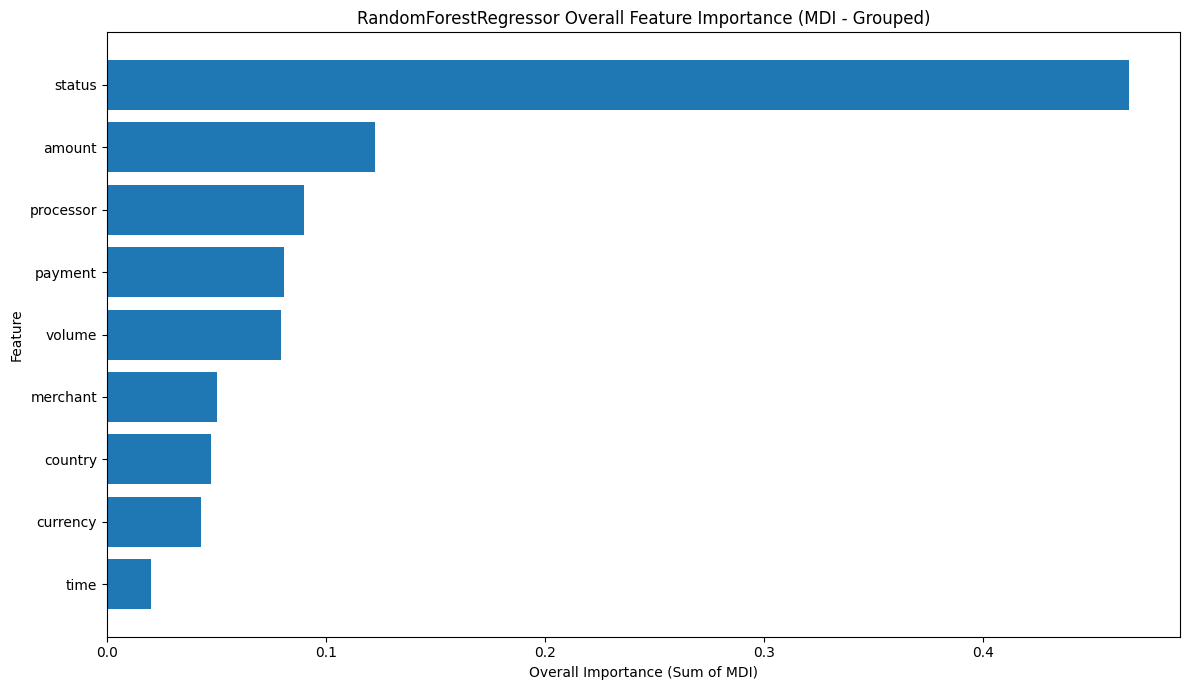

In [13]:
# --- 3. Preprocess Categorical Features (One-Hot Encoding) ---
# This converts categorical columns into numerical ones (dummy variables)
# This is crucial before scaling or training many models.
X_processed = pd.get_dummies(X, columns=['currency', 'country', 'payment_method', 'merchant_category', 'processor', 'status', 'time_of_day'], drop_first=True)

# --- 4. Perform Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# --- 5. IMPORTANT: Capture feature names *before* scaling if you're going to scale ---
# These are the column names that correspond to the features after one-hot encoding.
# We'll use these to map importances back to original features.
feature_names_after_ohe = X_train.columns.tolist()

# --- 6. Apply Numerical Feature Scaling (Optional but good practice for some models) ---
# For RandomForestRegressor, scaling is often not strictly necessary as it's a tree-based model
# and works on feature splits, but it doesn't harm.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train your RandomForestRegressor ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train) # Model is trained on the scaled NumPy array

# --- 8. Get Feature Importances from the trained model ---
# This gives importances for each individual one-hot encoded column.
importances = model.feature_importances_

# --- 9. Sum Importances for Grouped Features ---
# Create a Series for easier manipulation, mapping importances to their column names
importance_series = pd.Series(importances, index=feature_names_after_ohe)

grouped_importances = {}
for col_name, importance_value in importance_series.items():
    # Heuristic: Check if the column name contains an underscore, which usually
    # indicates it's a one-hot encoded column (e.g., 'country_USA').
    if '_' in col_name and any(cat_col in col_name for cat_col in ['currency', 'country', 'payment_method', 'merchant_category', 'processor', 'status', 'time_of_day']):
        # Extract the original categorical feature name (e.g., 'country' from 'country_USA')
        # This assumes your original categorical column names don't contain underscores.
        original_feature = col_name.split('_')[0]
        grouped_importances[original_feature] = grouped_importances.get(original_feature, 0) + importance_value
    else:
        # If no underscore or it's a numerical feature, keep its name as is.
        # This covers numerical_feat_1, numerical_feat_2, etc.
        grouped_importances[col_name] = importance_value

# Convert the grouped importances dictionary back to a DataFrame for plotting
overall_feature_importance_df = pd.DataFrame(
    list(grouped_importances.items()), columns=['feature', 'overall_importance']
).sort_values(by='overall_importance', ascending=False)

# --- 10. Print and Visualize Overall Feature Importances ---
print("Overall Feature Importances (Grouped by Original Feature):")
print(overall_feature_importance_df)

plt.figure(figsize=(12, 7))
plt.barh(overall_feature_importance_df['feature'], overall_feature_importance_df['overall_importance'])
plt.xlabel("Overall Importance (Sum of MDI)")
plt.ylabel("Feature")
plt.title("RandomForestRegressor Overall Feature Importance (MDI - Grouped)")
plt.gca().invert_yaxis() # To show the most important feature at the top
plt.tight_layout()
plt.show()

In [ ]:
# --- 5. Correctly Identify Column Types for Preprocessing ---
# Define cat_cols and num_cols based on X_train's dtypes
# This ensures that the type identification is based ONLY on training data properties.
# No X['time_of_day'] = X['time_of_day'].astype('object') here, as X_train will handle it
# If 'time_of_day' is a 'category' dtype, OneHotEncoder can handle it directly.
# If you need it as 'object' for some reason, do X_train['time_of_day'].astype('object') before this.
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X_train[col])]
num_cols = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]

print(f"Numerical columns for scaling: {num_cols}")
print(f"Categorical columns for OneHot Encoding: {cat_cols}")
print("-" * 50)


# --- 6. Create the Preprocessor ---
feature_preprocessor = ColumnTransformer(
    transformers=[
        #('scaler', StandardScaler(), num_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='drop' # Change to 'drop' to explicitly drop any columns not handled
)


In [ ]:
# --- 7. Apply Feature Transformation ---
# fit_transform on X_train; transform on X_test
X_train_transformed = feature_preprocessor.fit_transform(X_train)
X_test_transformed = feature_preprocessor.transform(X_test)

print("X_train_transformed shape:", X_train_transformed.shape)
print("X_test_transformed shape:", X_test_transformed.shape)
print("-" * 50)

# --- 8. Target column transformation ---
# target_transformer = LabelEncoder()
# y_train_transformed = target_transformer.fit_transform(y_train)
# y_test_transformed = target_transformer.transform(y_test)

# print("y_train_transformed (first 5):", y_train_transformed[:5])
# print("y_test_transformed (first 5):", y_test_transformed[:5])
# print("Original target classes:", target_transformer.classes_)
# print("-" * 50)

In [ ]:
# --- 9. Train the RandomForestClassifier ---
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)
print("Model training complete.")
print("-" * 50)

# --- 10. Evaluate the Model ---
y_pred_transformed = model.predict(X_test_transformed)
#y_pred_proba_transformed = model.predict(X_test_transformed) # This will be 2D. Take the correct class later.

# If your target is binary (like success/failure), y_pred_proba_transformed[:, 1] is correct for ROC AUC.
# If it's multi-class, you might need a different approach for AUC or use 'ovr'/'ovo' settings.
# Based on your previous report showing 7 classes, it is multi-class.
# For multi-class ROC AUC, you'll need to specify multi_class='ovr' or 'ovo' and average.
# For multi-class, predict_proba returns probabilities for all classes.
# y_pred_proba_transformed will be shape (n_samples, n_classes).

# For multi-class classification report, use the transformed y_test and y_pred
print("### Accuracy")
# Use y_test_transformed for accuracy, which will be the numeric labels (0, 1, 2, ...)
print(mean_absolute_error(y_test, y_pred_transformed))
print(r2_score(y_test, y_pred_transformed))
# print("\n### Classification Report ###")
# print(classification_report(y_test_transformed, y_pred_transformed, target_names=target_transformer.classes_))

# print("\n### Confusion Matrix ###")
# cm = confusion_matrix(y_test_transformed, y_pred_transformed)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=target_transformer.classes_,
#             yticklabels=target_transformer.classes_)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # For multi-class ROC AUC, you need to use the 'multi_class' parameter and an 'average' method.
# # 'ovr' (one-vs-rest) is a common choice.
# # The y_pred_proba should be the full 2D array of probabilities (not just[:,1])
# # For multi-class, class_weight='balanced' in RandomForestClassifier should also be fine.
# roc_auc = roc_auc_score(y_test_transformed, y_pred_proba_transformed, multi_class='ovr', average='macro')
# print(f"\n### ROC AUC Score (Multi-class, OVR, Macro Avg): {roc_auc:.4f} ###")

# # Precision-Recall Curve is typically for binary classification.
# # For multi-class, you often compute one-vs-rest PR curves for each class, or a micro/macro average.
# # If you want to plot PR curves for each class:
# plt.figure(figsize=(10, 8))
# for i, class_name in enumerate(target_transformer.classes_):
#     precision, recall, _ = precision_recall_curve(y_test_transformed == i, y_pred_proba_transformed[:, i])
#     pr_auc_class = auc(recall, precision)
#     plt.plot(recall, precision, label=f'PR curve for {class_name} (area = {pr_auc_class:.2f})')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve (One-vs-Rest) for Each Class')
# plt.legend(loc='lower left')
# plt.grid(True)
# plt.show()

In [ ]:
importances = model.feature_importances_

# 4. Create a DataFrame for better visualization (optional but recommended)
feature_names = X_train_transformed
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 5. Print or visualize the feature importances
print("Feature Importances (Mean Decrease Impurity):")
print(feature_importance_df)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("RandomForestRegressor Feature Importance (MDI)")
plt.gca().invert_yaxis() # To have the most important feature at the top
plt.show()

In [ ]:
# # Define the parameter grid to search
# param_grid = {
#     'n_estimators': [50, 100, 200], # Number of trees in the forest
#     'max_features': ['sqrt', 'log2'], # Number of features to consider when looking for the best split
#     'max_depth': [10, 20, None], # Maximum depth of the tree (None means unlimited)
#     'min_samples_leaf': [1, 2, 4] # Minimum number of samples required to be at a leaf node
# }

# # Create the GridSearchCV object
# # Using 'f1_weighted' as a scoring metric for multi-class classification with imbalanced classes
# # 'roc_auc_ovr_weighted' is also a good choice if you want to optimize for AUC in multi-class
# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            cv=3, # Number of cross-validation folds
#                            scoring='f1_weighted', # Metric to optimize
#                            verbose=2, # Higher verbosity for more output during search
#                            n_jobs=-1) # Use all available cores

# print("Starting Grid Search...")
# # Fit Grid Search to the transformed training data
# grid_search.fit(X_train_transformed, y_train_transformed)
# print("Grid Search complete.")
# print("-" * 50)

# # --- 10. Get Best Parameters and Best Model ---
# print("Best parameters found by Grid Search:")
# print(grid_search.best_params_)
# print("\nBest F1-weighted score on training data (cross-validation):")
# print(grid_search.best_score_)
# print("-" * 50)

# # Get the best estimator (model) from Grid Search
# best_model = grid_search.best_estimator_

# print("Evaluating the best model...")
# # --- 11. Evaluate the Best Model ---
# y_pred_transformed = best_model.predict(X_test_transformed)
# y_pred_proba_transformed = best_model.predict_proba(X_test_transformed)

# print("### Accuracy of Best Model ###")
# print(accuracy_score(y_test_transformed, y_pred_transformed))

# print("\n### Classification Report of Best Model ###")
# print(classification_report(y_test_transformed, y_pred_transformed, target_names=target_transformer.classes_))

# print("\n### Confusion Matrix of Best Model ###")
# cm = confusion_matrix(y_test_transformed, y_pred_transformed)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=target_transformer.classes_,
#             yticklabels=target_transformer.classes_)
# plt.title('Confusion Matrix (Best Model)')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # Calculate and print ROC AUC for multi-class
# # roc_auc_score requires y_true and y_score (probabilities)
# # For multi-class, it needs to be calculated with 'ovr' or 'ovo' strategy
# try:
#     roc_auc_ovr_weighted = roc_auc_score(y_test_transformed, y_pred_proba_transformed,
#                                          multi_class='ovr', average='weighted')
#     print(f"\n### ROC AUC Score (Multi-class, OVR, Weighted Avg) for Best Model: {roc_auc_ovr_weighted:.4f} ###")
# except ValueError as e:
#     print(f"\nCould not calculate ROC AUC score: {e}. This might happen if there's only one class present in y_true or y_score for a given OVR comparison.")


# # Precision-Recall Curve is typically for binary classification.
# # For multi-class, you often compute one-vs-rest PR curves for each class, or a micro/macro average.
# # If you want to plot PR curves for each class:
# plt.figure(figsize=(10, 8))
# for i, class_name in enumerate(target_transformer.classes_):
#     precision, recall, _ = precision_recall_curve(y_test_transformed == i, y_pred_proba_transformed[:, i])
#     pr_auc_class = auc(recall, precision)
#     plt.plot(recall, precision, label=f'PR curve for {class_name} (area = {pr_auc_class:.2f})')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve (One-vs-Rest) for Each Class (Best Model)')
# plt.legend(loc='lower left')
# plt.grid(True)
# plt.show()


**It shows a model that is more effective at correctly identifying successful transactions (higher True Positives and lower False Negatives), which is generally crucial for a payment routing system.**

In [ ]:
# def predict_best_processor(new_transaction_data, feature_preprocessor, best_model, target_transformer, all_processors, X_train_columns):
#     """
#     Predicts the best processor for a new transaction based on success probability.

#     Args:
#         new_transaction_data (dict): A dictionary containing features of the new transaction,
#                                      EXCLUDING 'processor' and 'status'.
#                                      Example: {'amount': 150.0, 'currency': 'USD', 'time_of_day': 'Morning'}
#         feature_preprocessor (ColumnTransformer): The fitted preprocessor.
#         best_model (RandomForestClassifier): The trained best model.
#         target_transformer (LabelEncoder): The fitted target transformer.
#         all_processors (np.array): An array of all unique processor names from the training data.
#         X_train_columns (pd.Index): The columns of the original X_train DataFrame, used for consistent column order.

#     Returns:
#         tuple: A tuple containing (best_processor_name, highest_probability, all_probabilities_dict).
#     """
#     processor_probabilities = {}

#     # Find the index of the 'success' class in the target transformer
#     # This assumes 'success' is one of the classes. If not, adjust accordingly.
#     if 'success' not in target_transformer.classes_:
#         print("Warning: 'success' class not found in target_transformer.classes_.")
#         # You might need to decide how to handle this, e.g., pick the most frequent class, or raise an error.
#         # For now, we'll assume 'success' is present.
#         return None, None, {}

#     success_class_idx = np.where(target_transformer.classes_ == 'success')[0][0]

#     for processor_name in all_processors:
#         # Create a dictionary with all expected columns from X_train, initialized to NaN
#         transaction_row_dict = {col: np.nan for col in X_train_columns}
        
#         # Populate the dictionary with the provided new_transaction_data
#         for key, value in new_transaction_data.items():
#             if key in transaction_row_dict:
#                 transaction_row_dict[key] = value
        
#         # Set the current hypothetical processor
#         transaction_row_dict['processor'] = processor_name
        
#         # Convert the dictionary to a DataFrame with a single row, ensuring column order matches X_train
#         new_transaction_df = pd.DataFrame([transaction_row_dict], columns=X_train_columns)

#         # Transform the new transaction data using the fitted preprocessor
#         # This handles scaling numerical features and one-hot encoding categorical features
#         transformed_transaction = feature_preprocessor.transform(new_transaction_df)

#         # Predict probabilities using the best trained model
#         probabilities = best_model.predict_proba(transformed_transaction)

#         # Get the probability of 'success' for the current processor
#         success_probability = probabilities[0, success_class_idx]
#         processor_probabilities[processor_name] = success_probability

#     # Find the processor with the highest success probability
#     if not processor_probabilities: # Handle case where no processors were processed
#         return None, None, {}

#     best_processor = max(processor_probabilities, key=processor_probabilities.get)
#     highest_probability = processor_probabilities[best_processor]

#     return best_processor, highest_probability, processor_probabilities

# # --- Dummy Data and Model Setup for Demonstration ---
# # In a real scenario, 'data', 'feature_preprocessor', 'best_model',
# # and 'target_transformer' would be loaded from a trained pipeline.
# # This section creates dummy versions for the code to be runnable.

# # 1. Create dummy data
# data = pd.DataFrame({
#     'amount': [100.0, 50.0, 200.0, 75.0, 120.0, 300.0, 90.0, 150.0, 60.0, 250.0],
#     'currency': ['USD', 'EUR', 'USD', 'EUR', 'GBP', 'USD', 'EUR', 'GBP', 'USD', 'EUR'],
#     'time_of_day': ['Morning', 'Evening', 'Afternoon', 'Night', 'Morning', 'Evening', 'Afternoon', 'Night', 'Morning', 'Evening'],
#     'processor': ['ProcessorA', 'ProcessorB', 'ProcessorA', 'ProcessorC', 'ProcessorB', 'ProcessorA', 'ProcessorC', 'ProcessorB', 'ProcessorB', 'ProcessorC'],
#     'status': ['success', 'fail', 'success', 'success', 'fail', 'success', 'fail', 'success', 'success', 'fail']
# })

# # 2. Define features (X) and target (y)
# X = data[['amount', 'currency', 'time_of_day', 'processor']]
# y = data['status']

# # 3. Split data (optional for this demo, but good practice)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 4. Create a dummy feature preprocessor
# numerical_features = ['amount']
# categorical_features = ['currency', 'time_of_day', 'processor']

# feature_preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Fit the preprocessor on X_train
# feature_preprocessor.fit(X_train)

# # 5. Create a dummy target transformer (LabelEncoder)
# target_transformer = LabelEncoder()
# target_transformer.fit(y_train) # Fit on the training target

# # 6. Create and train a dummy best model (RandomForestClassifier)
# best_model = RandomForestClassifier(random_state=42)

# # Transform X_train using the fitted preprocessor
# X_train_transformed = feature_preprocessor.transform(X_train)

# # Encode y_train
# y_train_encoded = target_transformer.transform(y_train)

# # Train the model
# best_model.fit(X_train_transformed, y_train_encoded)

# # --- Example Usage for a New Transaction ---
# # Get all unique processors from the original dataset
# all_processors = data['processor'].unique()

# # Define a hypothetical new transaction (excluding 'processor' and 'status')
# # IMPORTANT: Ensure these features match the columns used in X_train (e.g., 'amount', 'currency', 'time_of_day')
# # and that their data types are consistent with your training data.
# sample_new_transaction = {
#     'amount': 7500.00,
#     'currency': 'EUR',
#     'time_of_day': 'Late Night' # This should be one of the 'time_of_day' labels: 'Night', 'Morning', 'Afternoon', 'Evening', 'Late Night'
# }

# print("\n--- Simulating New Transaction for Best Processor Selection ---")
# best_processor_name, highest_prob, all_probs = predict_best_processor(
#     sample_new_transaction,
#     feature_preprocessor,
#     best_model,
#     target_transformer,
#     all_processors,
#     X_train.columns # Pass X_train.columns to ensure consistent column order during prediction
# )

# print(f"\nNew Transaction Details: {sample_new_transaction}")
# print(f"Predicted Success Probabilities for each processor: {all_probs}")
# if best_processor_name:
#     print(f"Recommended Processor: {best_processor_name} with success probability: {highest_prob:.4f}")
# else:
#     print("Could not determine best processor. Check for warnings/errors above.")
